In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
sns.set_style("darkgrid")
%matplotlib inline

# Hypothesis Test

## Data import

In [2]:
df = pd.read_csv('yellow_tripdata_2017-01_subset10000rows.csv')
np.random.seed(0)

In [3]:
#select first 1k distance as population
trip_distance = df.trip_distance.dropna().iloc[:1000]

## Sample

In [4]:
#pick a sample size 
n = 50

In [5]:
# take a sample from the population

# randomly permute the indexs
idx = np.random.permutation(len(trip_distance))
#pick the first n index
sample_idx = idx[:n]
#select them from trip_distance
sample = trip_distance.iloc[sample_idx]

In [6]:
sample

993     0.96
859     1.20
298     1.01
553     1.80
672     3.26
971     0.51
27      0.60
231     0.88
306     4.10
706     4.13
496     1.40
558     1.63
784     1.40
239     4.20
578     1.97
55      1.13
906     0.90
175     0.90
14      2.99
77      1.25
31      2.07
481     2.80
310     4.87
311     3.00
883     0.89
788     1.47
45      1.70
103     0.60
760     2.40
1       1.16
823     4.30
710     1.50
614     1.50
790     2.40
408     1.23
736     1.35
957     2.77
366     1.77
918     1.87
267     0.98
230     6.33
996     3.20
635     3.63
698     7.10
251     2.87
783     1.51
819    14.99
141     2.06
316     4.23
587     1.80
Name: trip_distance, dtype: float64

In [7]:
#there's new np function like this, but not returning a pd.series
np.random.choice(a = trip_distance, size=n, replace=False, p=None)
#p is probability

array([10.91,  4.  ,  5.4 ,  0.97,  1.74,  1.01,  3.09,  0.91,  2.1 ,
        0.7 ,  1.79,  0.27,  1.1 ,  1.93,  1.2 ,  2.68,  0.63,  1.35,
        2.1 , 17.64,  3.8 ,  7.32,  1.46,  8.1 ,  2.2 ,  1.4 ,  2.4 ,
        1.8 ,  2.94,  0.91, 12.1 ,  2.  ,  0.6 ,  1.2 ,  0.41,  1.27,
        4.43,  2.1 ,  7.82,  2.65,  1.63,  3.1 ,  0.86,  2.4 ,  0.8 ,
        1.5 , 11.7 ,  1.8 ,  1.1 ,  1.74])

In [8]:
#but we can still have
sample_idx = np.random.choice(a = len(trip_distance), size = n, replace = False)
sample = trip_distance.iloc[sample_idx]
#this sample is a pd.series
sample.describe()

count    50.000000
mean      3.260400
std       4.072719
min       0.000000
25%       0.910000
50%       1.465000
75%       3.950000
max      19.600000
Name: trip_distance, dtype: float64

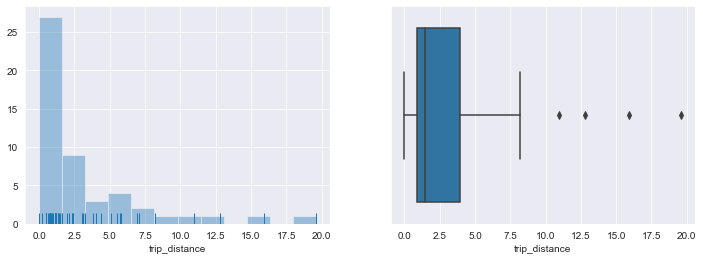

In [9]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
sns.distplot(sample, kde=False, rug=True, ax=ax[0]);
sns.boxplot(sample, ax=ax[1]);

By CLT, the mean of the distribution should be normal

In [10]:
xbar = sample.mean()
f'sample mean: {xbar:0.2f}'

'sample mean: 3.26'

In [11]:
np.random.seed(None)

In [12]:
sample_means = []
for i in range(1000):
    idx = np.random.choice(a = len(trip_distance), size = n, replace = False)
    sample_means.append(trip_distance.iloc[idx].mean())

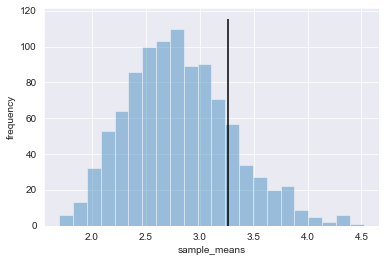

In [13]:
ax = sns.distplot(sample_means, kde=False)
ax.set_xlabel('sample_means');
ax.set_ylabel('frequency');
ax.vlines(xbar,*ax.get_ylim());
#vertical lines have a x coordinate and two y variable

Typically we only have one sample, we can bootstrap and generate a confidence interval, by which we can test "mean of distance = xxx"

trip_distance is our original sample

In [14]:
n = len(trip_distance)
n

1000

In [15]:
x_bar = trip_distance.mean()
print(f'sample mean: {x_bar:0.4f}')

sample mean: 2.8324


## Bootstrap sampling

### An newer version

In [16]:
def generate_bootstrap_new(X, size=None):
    # default return size of bootstrap is len(X)
    if not size:
        size = len(X)
        
    # resample from X size times with replacement
    sample = np.random.choice(X, size = size, replace = True)
    return sample

In [17]:
num_iterations = 500
bootstrap_means = [np.mean(generate_bootstrap_new(trip_distance.values)) \
                       for i in range(num_iterations)]
bootstrap_means = np.array(bootstrap_means)

a by-count approach

In [18]:
# 4. for an 95% conf. int., trim off 0.5*(1-0.95) of the data from both ends
# sort the statistics
bootstrap_means.sort()
# calculate where to trim
trim = .5*(1-.95) * num_iterations
# find the closest integer
trim = int(np.round(trim))
# 5. those trim points are the endpoints of the the  alpha%  bootstrap conf int
ci = bootstrap_means[[trim,-trim]]
ci

array([2.60973, 3.09466])

a statistical approach

In [19]:
ci2 = np.array([bootstrap_means.mean()-2*bootstrap_means.std(),\
          bootstrap_means.mean()+2*bootstrap_means.std()])

A visualization

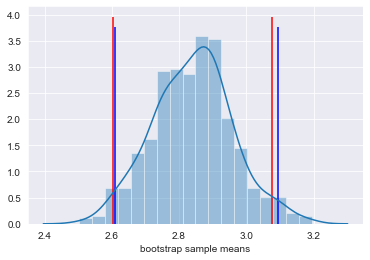

In [20]:
fig,ax = plt.subplots(1,1,figsize = (6,4))
sns.distplot(bootstrap_means, ax = ax)
ax.set_xlabel('bootstrap sample means')
ax.vlines(ci, *ax.get_ylim(), color='b');
ax.vlines(ci2, *ax.get_ylim(), color='r');

Another 1-step approach by sns

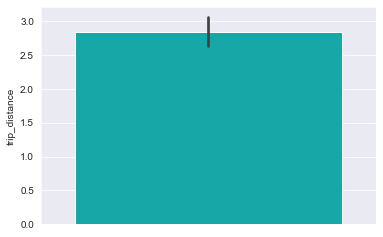

In [21]:
sns.barplot(trip_distance,
            estimator=np.mean, #default
            ci=95,             #default
            n_boot=100,        #default
            orient='v',
            color='c',
           );

### P.S.1 : An older version easier to understand

In [22]:
import time

In [23]:
def generate_bootstrap_old(X, size=None):
    # get the length of the data
    len_X = len(X)
    
    # default size of bootstrap is len(X)
    if not size:
        size = len_X
        
    # resample from X size times
    sample = []
    for i in range(size):
        idx = np.random.randint(len_X)
        sample.append(X[idx])
    return sample

In [24]:
# 3. repeat 1 and 2 many times
num_iterations = 500
bootstrap_means = []

time_start=time.time()
for i in range(num_iterations):
    # 1. draw a random sample of size *n* from the data
    bootstrap = generate_bootstrap_old(trip_distance.values)
    
    # 2. record the sample statistic from this random sample
    bootstrap_means.append(np.mean(bootstrap))
time_end=time.time()
print(f"time cost: {time_end - time_start}s")
bootstrap_means = np.array(bootstrap_means)

time cost: 5.567336082458496s


### P.S.2 a for loop version with new bootstrap, generator is still quicker!

In [25]:
num_iterations = 500
time_list = []
for t in range(100):
    time_start=time.time()
    bootstrap_means = [np.mean(generate_bootstrap_new(trip_distance.values)) \
                       for i in range(num_iterations)]
    bootstrap_means = np.array(bootstrap_means)
    time_end=time.time()
    time_list.append(time_end - time_start)
print(f"time cost: {np.mean(time_list)}s")

time cost: 0.028944377899169923s


In [26]:
#for loop with new bootstrap, it's slightly slower
num_iterations = 500
time_list = []
for i in range(100):
    time_start=time.time()
    bootstrap_means = []
    for i in range(num_iterations):
        # 1. draw a random sample of size *n* from the data
        bootstrap = generate_bootstrap_new(trip_distance.values)
        # 2. record the sample statistic from this random sample
        bootstrap_means.append(np.mean(bootstrap))
    bootstrap_means = np.array(bootstrap_means)
    time_end=time.time()
    time_list.append(time_end - time_start)
print(f"for loop with new bootstrap, time cost: {np.mean(time_list)}s")

for loop with new bootstrap, time cost: 0.028282411098480224s


# Bivariate: A/B Test : Webpages and Sales

1. select a given metric
2. randomly mix 2 types of data together, and select new groups with same size as original
3. compute metric with the new group
4. repeat 2 and 3
5. use data from 4 to generate distribution and test given metric

In [27]:
#data read-in
session_times = pd.read_csv('web_page_data.csv')
session_times.head(3)

,Page,Time
0,Page A,12.6
1,Page B,151.8
2,Page A,21.0


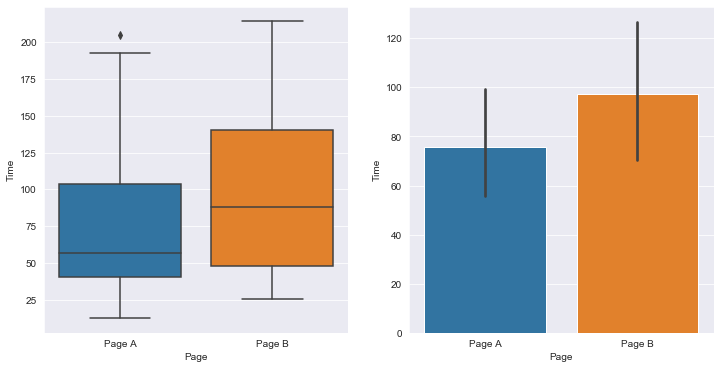

In [28]:
#exploratory analysis
fig, ax = plt.subplots(1,2,figsize = (12,6))
sns.boxplot(x='Page',y='Time',data=session_times, ax = ax[0]);
sns.barplot(x='Page',y='Time',data=session_times, ax = ax[1]);

Question: is page A and B really have difference in reading time?<br>
Metric: the measure we're interested in<br>
Ex: We're interested in a difference of means (Page B - Page A)

In [29]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
observed_metric = mean_b-mean_a
print('observed metric: {:0.2f}'.format(observed_metric))

observed metric: 21.40


In [30]:
# 0. get group sizes
n_a = sum(session_times.Page == 'Page A')#sum of boolean
n_b = sum(session_times.Page == 'Page B')

In [31]:
# combine groups together (assume H_0 is true)
samples = session_times.Time
# permute observations
permuted = np.random.permutation(session_times.Time)
# calculate metric
rand_mean_a = permuted[:n_a].mean()
rand_mean_b = permuted[n_a:].mean()
rand_mean_diff = (rand_mean_b - rand_mean_a)
print('{:.2f}'.format(rand_mean_diff))

-3.42


In [32]:
# repeated version
rand_mean_diffs = []
for i in range(10000):
    permuted = np.random.permutation(session_times.Time)
    rand_mean_a = permuted[:n_a].mean()
    rand_mean_b = permuted[n_a:].mean()
    rand_mean_diffs.append(rand_mean_b - rand_mean_a)

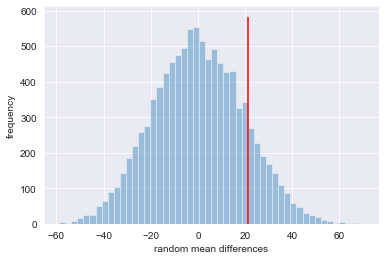

In [33]:
# 5. see where our original observation falls
ax = sns.distplot(rand_mean_diffs, norm_hist=False, kde=False)
ax.set_xlabel('random mean differences');
ax.set_ylabel('frequency');
ax.vlines(observed_metric, *ax.get_ylim(), color='r');

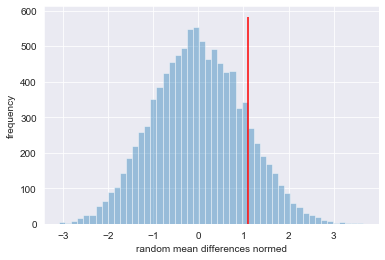

In [34]:
# 5. see where our original observation falls (normalized)
xbar = np.mean(rand_mean_diffs)
s = np.std(rand_mean_diffs)
rand_zscores = (rand_mean_diffs - xbar)/s
observed_metric_zscore = (observed_metric - xbar)/s

ax = sns.distplot(rand_zscores, norm_hist=False, kde=False)
ax.set_xlabel('random mean differences normed');
ax.set_ylabel('frequency');
ax.vlines(observed_metric_zscore, *ax.get_ylim(), color='r');

In [35]:
# find absolute values greater than our observed_metric
gt = np.abs(np.array(rand_mean_diffs)) >= np.abs(observed_metric)
# how many are greater?
num_gt = sum(gt)
# proportion of total that are as or more extreme
p = num_gt / len(rand_mean_diffs)
p

0.2692

### One-Tailed Test

In [36]:
sum(np.array(rand_mean_diffs) >= observed_metric) / len(rand_mean_diffs)

0.1373

### t-Test

In [37]:
t = sp.stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time.values,
                       session_times[session_times.Page == 'Page B'].Time.values,
                       equal_var=False)
t.pvalue

0.28152437245700607

### Another Ex: Price vs Conversion

In [38]:
df = pd.DataFrame({'Price A':[200,23539],
                   'Price B':[182,22406]},
                   index=['Conversion','No Conversion'])
df

,Price A,Price B
Conversion,200,182
No Conversion,23539,22406


Metric of Interest: difference in percent conversion

In [39]:
pct_conv = df.loc['Conversion'] / df.sum(axis=0) * 100
#axis = 0 means column direction
pct_conv

Price A    0.842495
Price B    0.805738
dtype: float64

In [40]:
diff_pct_conv = pct_conv['Price A'] - pct_conv['Price B']
print(f'{diff_pct_conv:.4f}%')

0.0368%


In [41]:
n = df.sum().sum()
n

46327

In [42]:
n_conversion = df.loc['Conversion'].sum()
n_conversion

382

In [43]:
#use 0 and 1 to stand for the conversion or not 
samples = np.zeros(n)
samples[:n_conversion] = 1  
assert sum(samples) == n_conversion

In [44]:
n_a, n_b = df.sum(axis=0)
print(n_a, n_b, n_a + n_b)
assert n_a + n_b == n

23739 22588 46327


In [45]:
%%time
rand_conv_diffs = []
for i in range(1000):
    permutation = np.random.permutation(samples)
    rand_conv_a = sum(permutation[:n_a]) / n_a
    rand_conv_b = sum(permutation[n_a:]) / n_b
    rand_conv_diffs.append(100 * (rand_conv_a - rand_conv_b))

CPU times: user 8.61 s, sys: 141 ms, total: 8.75 s
Wall time: 9.2 s


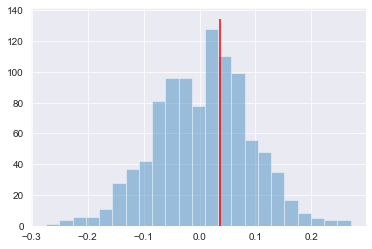

In [46]:
ax = sns.distplot(rand_conv_diffs, norm_hist=False, kde=False)
ax.vlines(diff_pct_conv, *ax.get_ylim(), color='r');

# How many observations?

Common question: How many observations do we need?

These 4 things are related:

effect size: Min size of effect you want to detect  
Ex: "10% increase in clicks"  

power: Prob. of detecting given effect size with given sample size  
P(reject H0∣H1 true)  

alpha: significance level at which to reject the null  
1−P(reject H0∣H0 true)  

number of observations: usually what we're interested in finding

In [47]:
from statsmodels.stats.power import tt_ind_solve_power
# choose one to set as None
x = tt_ind_solve_power(effect_size=.05, # diff between means divided by std dev
                       nobs1=None,
                       alpha=.05,       # type 1 error
                       power=.95,       # 1 - type 2 error
                       ratio=1          # n_a : n_b
                  )
print(f'num observations needed: {np.ceil(x)}')

num observations needed: 10397.0


What happens to our power if we can only get 1000 observations?

In [48]:
x = tt_ind_solve_power(effect_size=.05, # diff between means divided by std dev
                       nobs1=1000,      #number of observation
                       alpha=.05,       # type 1 error
                       power=None,      # 1 - type 2 error
                       ratio=1          # n_a : n_b
                  )
print(f'power: {x:0.2f}')

power: 0.20


# Plot a N(0,1)

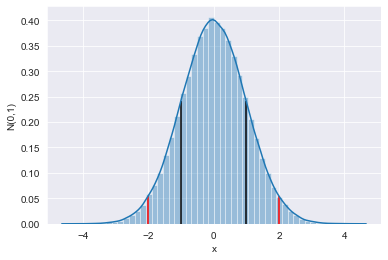

In [49]:
import scipy as sp
x = np.random.normal(0,1,size=100000)
ax = sns.distplot(x);
ax.set_xlabel('x');ax.set_ylabel('N(0,1)')
ax.vlines([-1,1],0,sp.stats.norm.pdf(1), colors='k');
ax.vlines([-2,2],0,sp.stats.norm.pdf(2), colors='r');

# MAB(Multi-Armed Bandit)

1. We have two ads
2. We don't know how often each will lead to a response
3. We need to decide which ad to add to each page request

In [50]:
np.random.seed(7) # so the example is consistent
# creating two ads (distributions) with unknown response rate
ad_A = sp.stats.bernoulli(p=np.random.rand())
ad_B = sp.stats.bernoulli(p=np.random.rand())

In [51]:
# epsilon probability for epsilon-MAB
epsilon = 0.40

In [52]:
#round 1
pulls_A = [ad_A.rvs()]#rvs(p, loc=0, size=1, random_state=None) Random variates.
#round 2
pulls_B = [ad_B.rvs()]
pulls_A,pulls_B

([0], [1])

In [53]:
#Round 3
#With probability 1−ϵ, choose the best arm (A)
be_greedy = np.random.rand() > epsilon
be_greedy

True

In [54]:
pulls_B.append(ad_B.rvs())
pulls_A,pulls_B

([0], [1, 1])

In [55]:
def mab(ad_A,ad_B,pulls_A,pulls_B,epsilon):
    #roll a random number
    be_greedy = np.random.rand() > epsilon
    
    #of randomly choose
    if not be_greedy: 
        if np.random.rand() < 0.5:
            pulls_A.append(ad_A.rvs())
            choice = 'A'
        else:
            pulls_B.append(ad_B.rvs())
            choice = 'B'
    # be greedy
    else: 
        #compute the ratio
        resp_A = sum(pulls_A) / len(pulls_A)
        resp_B = sum(pulls_B) / len(pulls_B)
        #choose the greedy
        if resp_A > resp_B:
            pulls_A.append(ad_A.rvs())
            choice = 'A'
        else:
            pulls_B.append(ad_B.rvs())
            choice = 'B'
    return pulls_A, pulls_B, be_greedy, choice

In [56]:
pulls_A, pulls_B, be_greedy, choice = mab(ad_A,
                                          ad_B,
                                          pulls_A,
                                          pulls_B,
                                          epsilon)
print(be_greedy,choice,pulls_A, pulls_B)

True B [0] [1, 1, 1]


In [57]:
for i in range(10):
    pulls_A, pulls_B, be_greedy, choice = mab(ad_A,ad_B,pulls_A,pulls_B,epsilon)
    print(be_greedy,choice,pulls_A, pulls_B)

False A [0, 0] [1, 1, 1]
True B [0, 0] [1, 1, 1, 1]
False A [0, 0, 0] [1, 1, 1, 1]
False A [0, 0, 0, 1] [1, 1, 1, 1]
False B [0, 0, 0, 1] [1, 1, 1, 1, 0]
False B [0, 0, 0, 1] [1, 1, 1, 1, 0, 0]
False B [0, 0, 0, 1] [1, 1, 1, 1, 0, 0, 1]
True B [0, 0, 0, 1] [1, 1, 1, 1, 0, 0, 1, 1]
False A [0, 0, 0, 1, 0] [1, 1, 1, 1, 0, 0, 1, 1]
True B [0, 0, 0, 1, 0] [1, 1, 1, 1, 0, 0, 1, 1, 1]


In [58]:
print('conversion rates: A: {:0.2f} B: {:0.2f}'.format(np.mean(pulls_A),np.mean(pulls_B)))

conversion rates: A: 0.20 B: 0.78


In [59]:
f'ground truth: A: {ad_A.pmf(1):0.2f} B: {ad_B.pmf(1):0.2f}'

'ground truth: A: 0.08 B: 0.78'

In [60]:
for i in range(190):
    pulls_A, pulls_B, be_greedy, choice = mab(ad_A,ad_B,pulls_A,pulls_B,epsilon)

In [61]:
print(be_greedy,choice,pulls_A, pulls_B)

False B [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0] [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


In [62]:
print('conversion rates: A: {:0.2f} B: {:0.2f}'.format(np.mean(pulls_A),np.mean(pulls_B)))
#it has a good converge, although a little bit long

conversion rates: A: 0.14 B: 0.72
